In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, classification_report

from scipy.stats import norm
import lightgbm as lgb
import shap
import yaml

from hep_ml import splot
from aux_functions import fit_line, invert_regr

In [2]:
# plt.rcParams['text.usetex'] = True
# plt.rcParams["font.family"] = 'sans-serif'
sns.set_theme()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
df_ER_train = pd.read_csv('../data_studies/csv_data/df_ER.csv', index_col='Unnamed: 0')
df_NR_train = pd.read_csv('../data_studies/csv_data/df_NR.csv', index_col='Unnamed: 0')
df_train = pd.concat([df_ER_train, df_NR_train])
df_private = pd.read_csv('../data_studies/csv_data/df_private_test.csv', index_col='Unnamed: 0')

In [4]:
df_private['abs_dmu_x'] = np.abs(df_private['mu_x'] - 288)
df_private['abs_dmu_y'] = np.abs(df_private['mu_y'] - 288)

In [5]:
with open('region_params.yml') as f:
    region_params = yaml.load(f, Loader=yaml.FullLoader)

## calibration

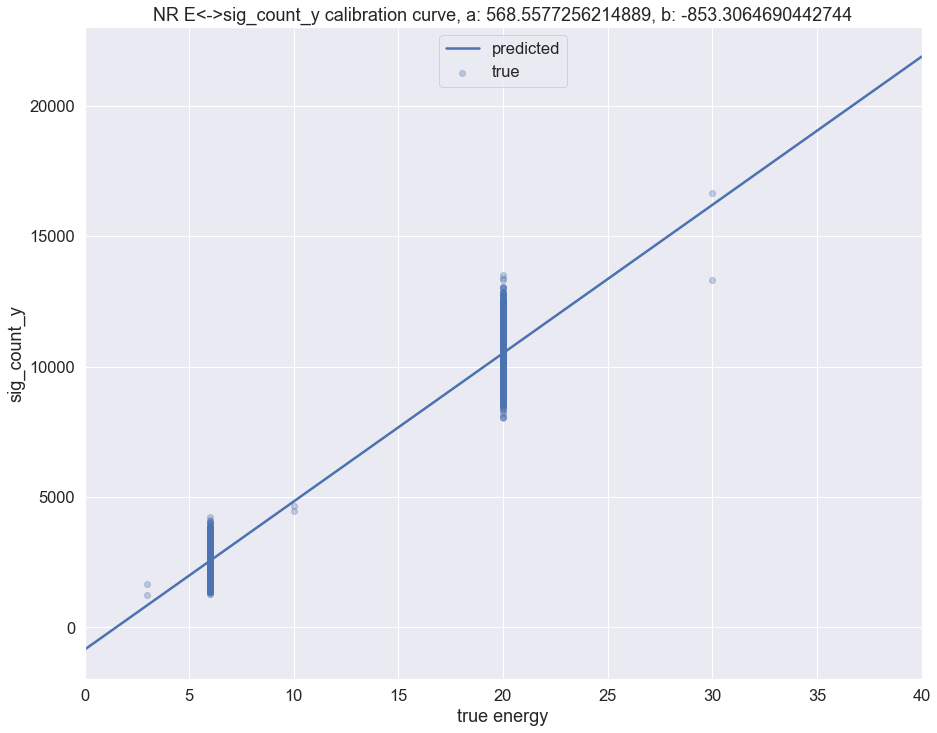

In [6]:
a, b = fit_line(df_train)

In [7]:
df_private['E_regr'] = invert_regr(a, b, df_private['sig_count_y'])
df_private['E_regr_x'] = invert_regr(a, b, df_private['sig_count_x'])

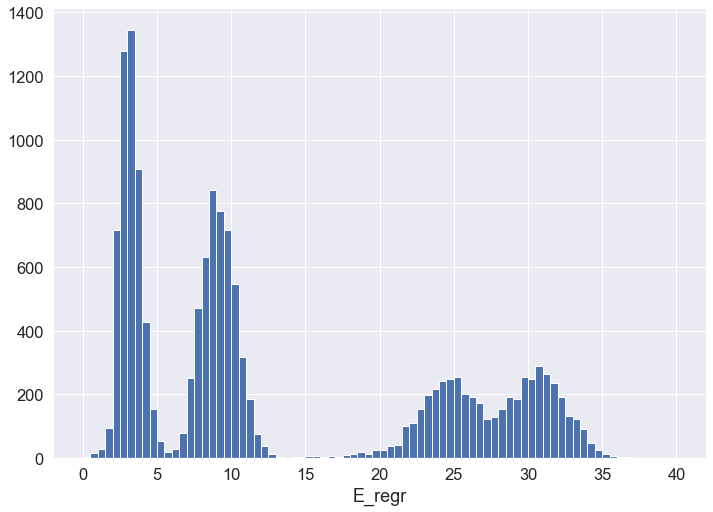

In [8]:
plt.hist(df_private['E_regr'], bins=80, range=(0., 40.))
plt.xlabel('E_regr')
plt.show()

## MID

In [9]:
MID_left, MID_right = region_params['MID']['left'], region_params['MID']['right']
MID_left, MID_right

(6.0, 14.0)

In [10]:
df_private_MID = df_private.query(f'E_regr >= {MID_left} and E_regr < {MID_right}')
E_regr_MID = df_private_MID.E_regr

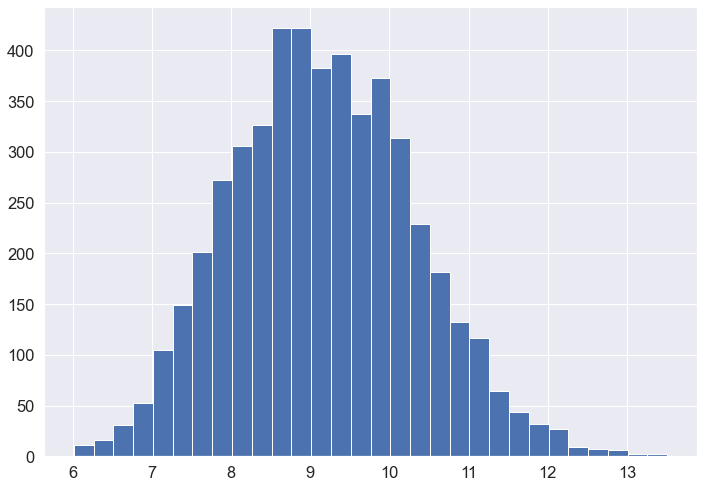

In [11]:
plt.hist(E_regr_MID, bins=30)
plt.show()

In [12]:
from iminuit import Minuit
from iminuit.cost import LeastSquares, UnbinnedNLL

In [13]:
def norm_pdf(x, mu, sigma):
    invs = 1.0 / sigma
    z = (x - mu) * invs
    invnorm = 1 / np.sqrt(2 * np.pi) * invs
    return np.exp(-0.5 * z ** 2) * invnorm

def uniform_pdf(x):
    obs_left, obs_right = 230, 350 # please forgive me my sins
    x_in_range = (x >= obs_left) & (x <= obs_right)
    return np.where(x_in_range, 1/(obs_right - obs_left), 0)

def model(x, mu_1, mu_2, sigma_1, sigma_2, fr):
    return fr*norm_pdf(x, mu_1, sigma_1) + (1-fr)*norm_pdf(x, mu_2, sigma_2)

In [14]:
nll = UnbinnedNLL(E_regr_MID, model)
m = Minuit(nll, mu_1=8.5, mu_2=9.5, sigma_1=1, sigma_2=1, fr=0.5)  # starting values for α and β
m.fixed['fr'] = True
m.migrad()
m.hesse()   

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,mu_1,8.52,0.05,,,,,
1,mu_2,9.81,0.05,,,,,
2,sigma_1,0.887,0.028,,,,,
3,sigma_2,1.04,0.04,,,,,
4,fr,0.500,0.005,,,,,yes


In [15]:
x = np.linspace(MID_left, MID_right)
fit_results = dict(m.values)
assert fit_results['mu_1'] < fit_results['mu_2']

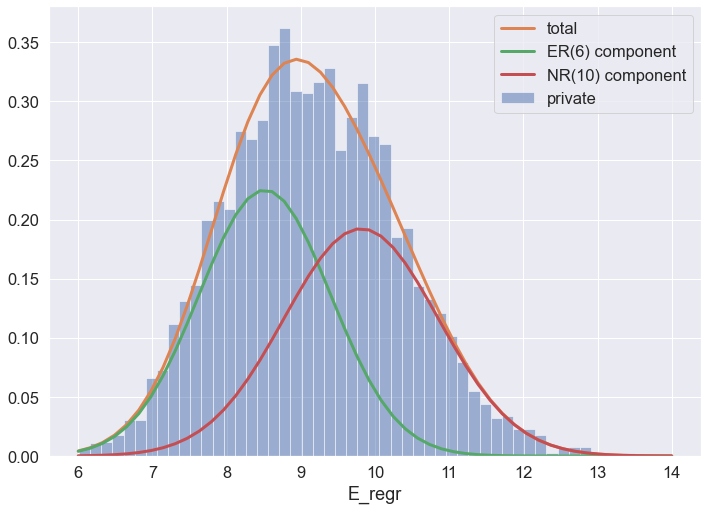

In [16]:
plt.hist(E_regr_MID, density=True, bins=50, label='private', alpha=0.5)
plt.plot(x, model(x, **fit_results), linewidth=3, label='total')
plt.plot(x, fit_results['fr']*norm_pdf(x, mu=fit_results['mu_1'], sigma=fit_results['sigma_1']), linewidth=3, label='ER(6) component')
plt.plot(x, fit_results['fr']*norm_pdf(x, mu=fit_results['mu_2'], sigma=fit_results['sigma_2']), linewidth=3, label='NR(10) component')
plt.xlabel('E_regr')
plt.legend()
plt.show()

In [17]:
probs_MID = pd.DataFrame(dict(sig=norm.pdf(E_regr_MID, loc=fit_results['mu_1'], scale=fit_results['sigma_1']), 
                              bck=norm.pdf(E_regr_MID, loc=fit_results['mu_2'], scale=fit_results['sigma_2'])))
probs_MID = probs_MID.div(probs_MID.sum(axis=1), axis=0)

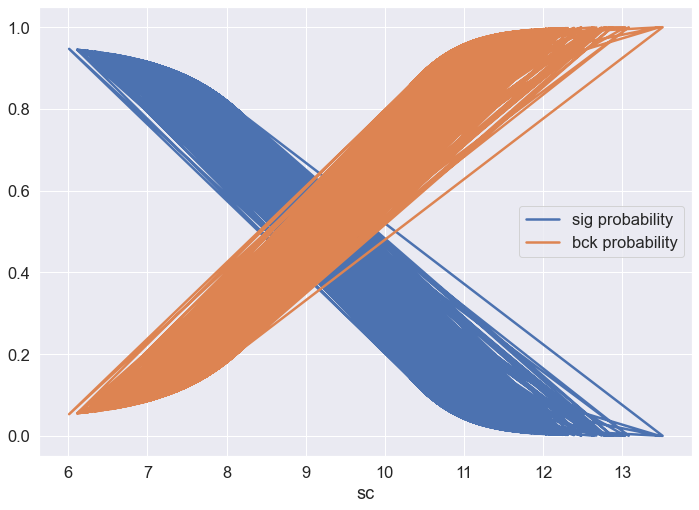

In [18]:
plt.plot(E_regr_MID, probs_MID.sig, label='sig probability')
plt.plot(E_regr_MID, probs_MID.bck, label='bck probability')
plt.legend(), plt.xlabel('sc')
plt.show()

In [19]:
sWeights_MID = splot.compute_sweights(probs_MID)

In [20]:
(list(df_private_MID.columns))

['N_bkgr_only_x',
 'N_bkgr_only_y',
 'N_error_bkgr_only_x',
 'N_error_bkgr_only_y',
 'N_error_x',
 'N_error_y',
 'N_x',
 'N_y',
 'bkgr_count_x',
 'bkgr_count_y',
 'chi2_bkgr_only_x',
 'chi2_bkgr_only_y',
 'chi2_pvalue_bkgr_only_x',
 'chi2_pvalue_bkgr_only_y',
 'chi2_pvalue_x',
 'chi2_pvalue_y',
 'chi2_x',
 'chi2_y',
 'dfr',
 'dmu',
 'dsigma',
 'edm_bkgr_only_x',
 'edm_bkgr_only_y',
 'edm_x',
 'edm_y',
 'event_ID',
 'event_angle',
 'event_class',
 'event_energy',
 'fr_error_x',
 'fr_error_y',
 'fr_x',
 'fr_y',
 'fval_bkgr_only_x',
 'fval_bkgr_only_y',
 'fval_x',
 'fval_y',
 'has_accurate_covar_bkgr_only_x',
 'has_accurate_covar_bkgr_only_y',
 'has_accurate_covar_x',
 'has_accurate_covar_y',
 'has_covariance_bkgr_only_x',
 'has_covariance_bkgr_only_y',
 'has_covariance_x',
 'has_covariance_y',
 'has_made_posdef_covar_bkgr_only_x',
 'has_made_posdef_covar_bkgr_only_y',
 'has_made_posdef_covar_x',
 'has_made_posdef_covar_y',
 'has_parameters_at_limit_bkgr_only_x',
 'has_parameters_at_limit

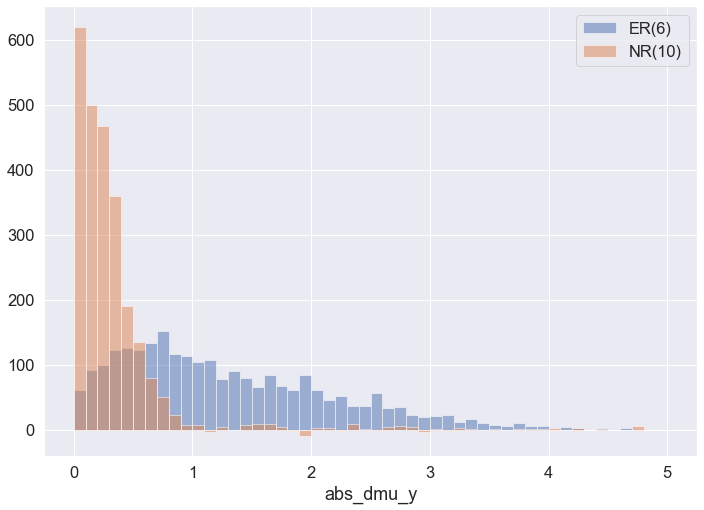

In [21]:
feature = 'abs_dmu_y'
plt.hist(df_private_MID[feature], weights=sWeights_MID.sig, bins=50, range=(0, 5), label='ER(6)', alpha=0.5)
plt.hist(df_private_MID[feature], weights=sWeights_MID.bck, bins=50, range=(0, 5), label='NR(10)', alpha=0.5)
plt.legend()
plt.xlabel(feature)
plt.show()

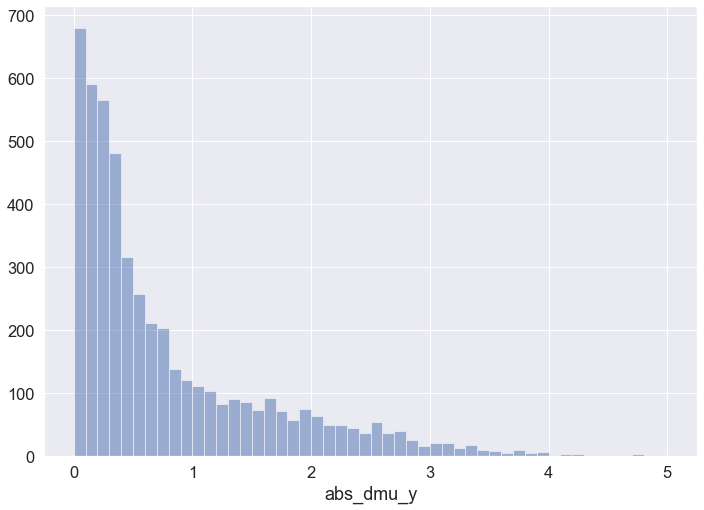

In [22]:
plt.hist(df_private_MID[feature], bins=50, range=(0, 5), label='ER(6)', alpha=0.5)
plt.xlabel(feature)
plt.show()

## LOW

In [23]:
LOW_left = 0
LOW_right = region_params['LOW']['right']
LOW_left, LOW_right

(0, 6.0)

In [24]:
df_private_LOW = df_private.query(f'E_regr >= {LOW_left} and E_regr < {LOW_right}')
E_regr_LOW = df_private_LOW.E_regr

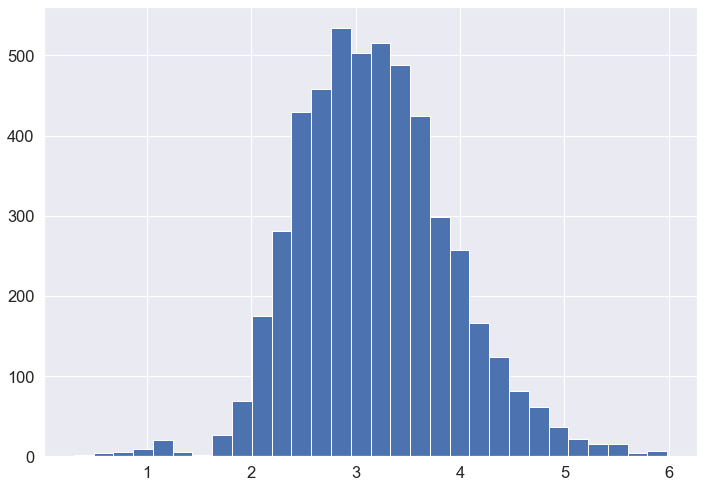

In [25]:
plt.hist(E_regr_LOW, bins=30)
plt.show()

In [26]:
nll = UnbinnedNLL(E_regr_LOW, model)
m = Minuit(nll, mu_1=2.8, mu_2=3.2, sigma_1=0.5, sigma_2=0.5, fr=0.5)  # starting values for α and β
m.fixed['fr'] = True
m.migrad()
m.hesse()   

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,mu_1,2.976,0.021,,,,,
1,mu_2,3.395,0.025,,,,,
2,sigma_1,0.512,0.012,,,,,
3,sigma_2,0.842,0.015,,,,,
4,fr,0.500,0.005,,,,,yes


In [27]:
x = np.linspace(LOW_left, LOW_right)
fit_results = dict(m.values)
assert fit_results['mu_1'] < fit_results['mu_2']

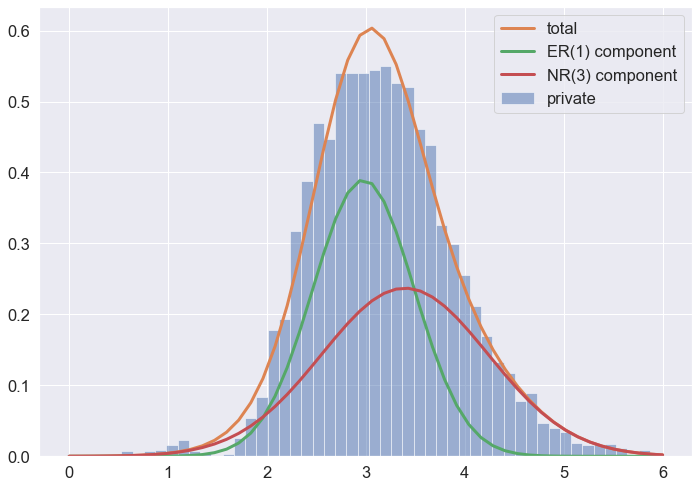

In [28]:
plt.hist(E_regr_LOW, density=True, bins=50, label='private', alpha=0.5)
plt.plot(x, model(x, **fit_results), linewidth=3, label='total')
plt.plot(x, fit_results['fr']*norm_pdf(x, mu=fit_results['mu_1'], sigma=fit_results['sigma_1']), linewidth=3, label='ER(1) component')
plt.plot(x, fit_results['fr']*norm_pdf(x, mu=fit_results['mu_2'], sigma=fit_results['sigma_2']), linewidth=3, label='NR(3) component')
plt.legend()
plt.show()

In [29]:
probs_LOW = pd.DataFrame(dict(sig=norm.pdf(E_regr_LOW, loc=fit_results['mu_1'], scale=fit_results['sigma_1']), 
                              bck=norm.pdf(E_regr_LOW, loc=fit_results['mu_2'], scale=fit_results['sigma_2'])))
probs_LOW = probs_LOW.div(probs_LOW.sum(axis=1), axis=0)

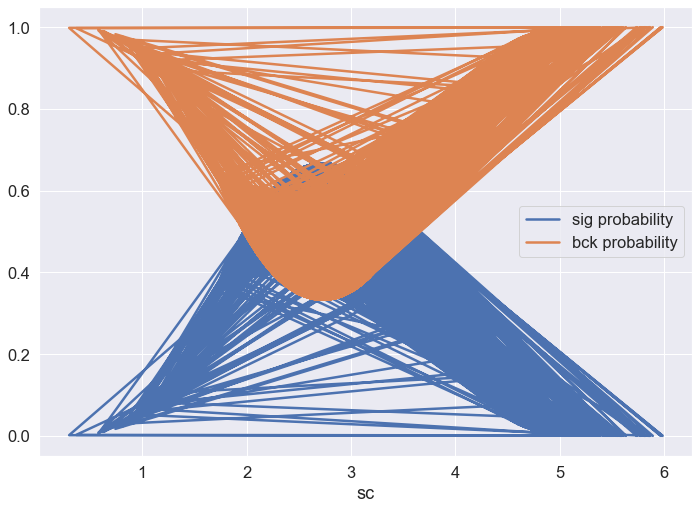

In [30]:
plt.plot(E_regr_LOW, probs_LOW.sig, label='sig probability')
plt.plot(E_regr_LOW, probs_LOW.bck, label='bck probability')
plt.legend(), plt.xlabel('sc')
plt.show()

In [31]:
sWeights_LOW = splot.compute_sweights(probs_LOW)

In [32]:
(list(df_private_LOW.columns))

['N_bkgr_only_x',
 'N_bkgr_only_y',
 'N_error_bkgr_only_x',
 'N_error_bkgr_only_y',
 'N_error_x',
 'N_error_y',
 'N_x',
 'N_y',
 'bkgr_count_x',
 'bkgr_count_y',
 'chi2_bkgr_only_x',
 'chi2_bkgr_only_y',
 'chi2_pvalue_bkgr_only_x',
 'chi2_pvalue_bkgr_only_y',
 'chi2_pvalue_x',
 'chi2_pvalue_y',
 'chi2_x',
 'chi2_y',
 'dfr',
 'dmu',
 'dsigma',
 'edm_bkgr_only_x',
 'edm_bkgr_only_y',
 'edm_x',
 'edm_y',
 'event_ID',
 'event_angle',
 'event_class',
 'event_energy',
 'fr_error_x',
 'fr_error_y',
 'fr_x',
 'fr_y',
 'fval_bkgr_only_x',
 'fval_bkgr_only_y',
 'fval_x',
 'fval_y',
 'has_accurate_covar_bkgr_only_x',
 'has_accurate_covar_bkgr_only_y',
 'has_accurate_covar_x',
 'has_accurate_covar_y',
 'has_covariance_bkgr_only_x',
 'has_covariance_bkgr_only_y',
 'has_covariance_x',
 'has_covariance_y',
 'has_made_posdef_covar_bkgr_only_x',
 'has_made_posdef_covar_bkgr_only_y',
 'has_made_posdef_covar_x',
 'has_made_posdef_covar_y',
 'has_parameters_at_limit_bkgr_only_x',
 'has_parameters_at_limit

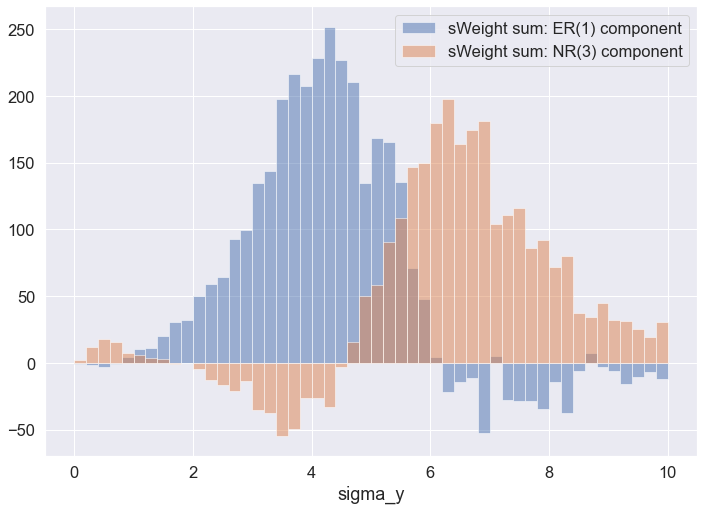

In [33]:
feature = 'sigma_y'
plt.hist(df_private_LOW[feature], weights=sWeights_LOW.sig, bins=50, range=(0, 10), label='sWeight sum: ER(1) component', alpha=0.5)
plt.hist(df_private_LOW[feature], weights=sWeights_LOW.bck, bins=50, range=(0, 10), label='sWeight sum: NR(3) component', alpha=0.5)
plt.legend()
plt.xlabel(feature)
plt.show()

## training on sWeights

### LOW

In [34]:
LOW_vars = [  
#     'chi2_pvalue_x', 'chi2_pvalue_y', 
#                'chi2_x', 'chi2_y',
#               'dfr', 
#               'dmu', #'dsigma', 
#               'fr_error_x', 'fr_error_y', 
#               'fr_x', 'fr_y',
#               'sigma_x', 
              'sigma_y', 
# #               'sigma_error_x', 'sigma_error_y', 
#               'mu_x', 'mu_y', 
#               'mu_error_x', 'mu_error_y', 
#               'n_excess_bins_x', 'n_excess_bins_y', 
#                'nfcn_total_x', 'nfcn_total_y',
#        'nfcn_x', 'nfcn_y', 'ngrad_total_x', 'ngrad_total_y', 'ngrad_x', 'ngrad_y', 
#               'sig_count_x', 
#                'sig_count_y', 
#               'sig_density_x', 'sig_density_y', 
#         'abs_dmu_x', 'abs_dmu_y',
]

In [35]:
df_sig = df_private_LOW[LOW_vars]
df_sig['w'] = sWeights_LOW.sig.values
df_sig['target'] = 1
#
df_bkgr = df_private_LOW[LOW_vars]
df_bkgr['w'] = sWeights_LOW.bck.values
df_bkgr['target'] = 0
#
df_sb = pd.concat([df_sig, df_bkgr])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [36]:
X = df_sb[LOW_vars]
y = df_sb['target']
w = df_sb['w']

In [37]:
clf_params ={
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'max_depth': 4,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 777
}

In [38]:
lgb_sTrain = lgb.Dataset(X, y, weight=w, free_raw_data=False)
sClf = lgb.train(
                clf_params,
                lgb_sTrain,
                num_boost_round=1000,
               )

In [39]:
sPred = sClf.predict(X)

In [40]:
df_sig.shape

(5038, 3)

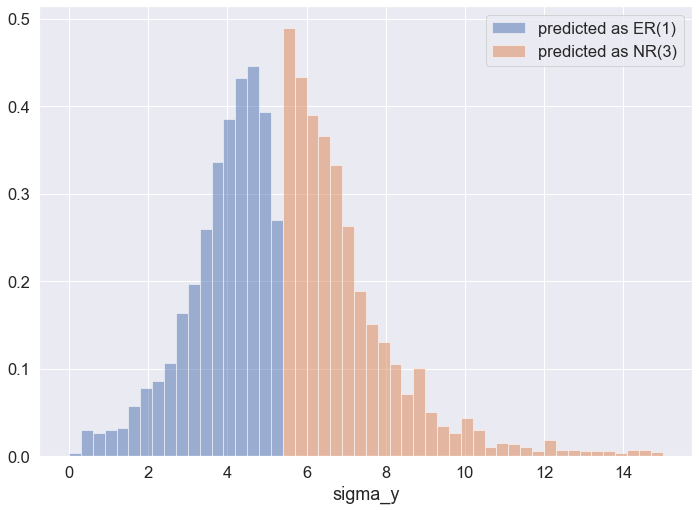

In [41]:
var = 'sigma_y'
len_private = df_private_LOW.shape[0]
plt.hist(df_private_LOW[sPred[:len_private] == 1][var], bins=50, alpha=0.5, range=(0, 15), density=True, label='predicted as ER(1)')
plt.hist(df_private_LOW[sPred[:len_private] == 0][var], bins=50, alpha=0.5, range=(0, 15), density=True, label='predicted as NR(3)')
plt.legend()
plt.xlabel(var)
plt.show()

### MID

In [42]:
MID_vars = [  
#     'chi2_pvalue_x', 'chi2_pvalue_y', 
#                'chi2_x', 'chi2_y',
#               'dfr', 
#               'dmu', #'dsigma', 
#               'fr_error_x', 'fr_error_y', 
#               'fr_x', 'fr_y',
#               'sigma_x', 
              'sigma_y', 
# #               'sigma_error_x', 'sigma_error_y', 
#               'mu_x', 'mu_y', 
#               'mu_error_x', 'mu_error_y', 
#               'n_excess_bins_x', 'n_excess_bins_y', 
#                'nfcn_total_x', 'nfcn_total_y',
#        'nfcn_x', 'nfcn_y', 'ngrad_total_x', 'ngrad_total_y', 'ngrad_x', 'ngrad_y', 
#               'sig_count_x', 
#                'sig_count_y', 
#               'sig_density_x', 'sig_density_y', 
#         'abs_dmu_x', 'abs_dmu_y',
]

In [43]:
df_sig = df_private_MID[MID_vars]
df_sig['w'] = sWeights_MID.sig.values
df_sig['target'] = 1
#
df_bkgr = df_private_MID[MID_vars]
df_bkgr['w'] = sWeights_MID.bck.values
df_bkgr['target'] = 0
#
df_sb = pd.concat([df_sig, df_bkgr])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [44]:
X = df_sb[MID_vars]
y = df_sb['target']
w = df_sb['w']

In [45]:
clf_params ={
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'max_depth': 4,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 777
}

In [46]:
lgb_sTrain = lgb.Dataset(X, y, weight=w, free_raw_data=False)
sClf = lgb.train(
                clf_params,
                lgb_sTrain,
                num_boost_round=1000,
               )

In [47]:
sPred = sClf.predict(X)

In [48]:
df_sig.shape

(4972, 3)

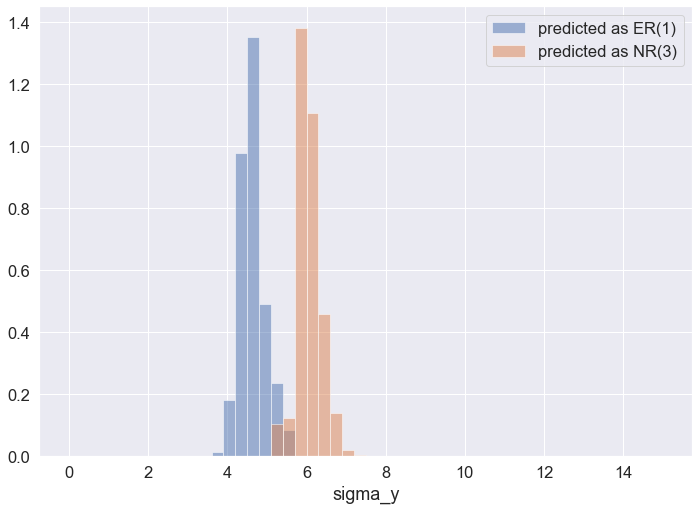

In [49]:
var = 'sigma_y'
len_private = df_private_MID.shape[0]
plt.hist(df_private_MID[sPred[:len_private] == 1][var], bins=50, alpha=0.5, range=(0, 15), density=True, label='predicted as ER(1)')
plt.hist(df_private_MID[sPred[:len_private] == 0][var], bins=50, alpha=0.5, range=(0, 15), density=True, label='predicted as NR(3)')
plt.legend()
plt.xlabel(var)
plt.show()